In [108]:

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (5, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'none'

In [2]:
df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180512.txt')

In [109]:
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,net_entries,net_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,00:00:00,REGULAR,6607801,2239047,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,04:00:00,REGULAR,6607821,2239051,20.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,08:00:00,REGULAR,6607830,2239083,9.0,32.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,12:00:00,REGULAR,6607921,2239160,91.0,77.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,16:00:00,REGULAR,6608151,2239219,230.0,59.0


In [18]:
df.columns = [col.lower().strip() for col in df.columns]

In [19]:
df['net_entries'] = df.entries - df.entries.shift()

df['net_exits'] = df.exits - df.exits.shift()


In [29]:
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,net_entries,net_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,00:00:00,REGULAR,6607801,2239047,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,04:00:00,REGULAR,6607821,2239051,20.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,08:00:00,REGULAR,6607830,2239083,9.0,32.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,12:00:00,REGULAR,6607921,2239160,91.0,77.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,16:00:00,REGULAR,6608151,2239219,230.0,59.0


In [113]:
df = df.fillna(0)

In [114]:
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,net_entries,net_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,00:00:00,REGULAR,6607801,2239047,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,04:00:00,REGULAR,6607821,2239051,20.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,08:00:00,REGULAR,6607830,2239083,9.0,32.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,12:00:00,REGULAR,6607921,2239160,91.0,77.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,16:00:00,REGULAR,6608151,2239219,230.0,59.0


In [115]:
df.net_entries.describe()

count    196655.000000
mean        179.178775
std         253.658928
min           0.000000
25%           7.000000
50%          73.000000
75%         251.000000
max        1831.000000
Name: net_entries, dtype: float64

In [ ]:
df.net_entries[df.net_entries < 0] = 0

In [33]:
df.net_entries[df.net_entries > df.net_entries.quantile(.987)] = 0

In [35]:
df.net_entries.describe()

count    196654.000000
mean        179.179686
std         253.659251
min           0.000000
25%           7.000000
50%          73.000000
75%         251.000000
max        1831.000000
Name: net_entries, dtype: float64

In [37]:
df.net_exits[df.net_exits < 0] = 0

In [38]:
df.net_exits[df.net_exits > df.net_exits.quantile(.987)] = 0

In [39]:
df.net_exits.describe()

count    196654.000000
mean        135.439274
std         215.188146
min           0.000000
25%           6.000000
50%          51.000000
75%         169.000000
max        1840.000000
Name: net_exits, dtype: float64

In [41]:
grouped_by_station = df.groupby('station').sum()

In [81]:
sorted_station_net_entries = grouped_by_station.sort_values(['net_entries'],\
                                                ascending = False)

In [ ]:
plt.bar(range(len(colors)), rates, tick_label=colors)


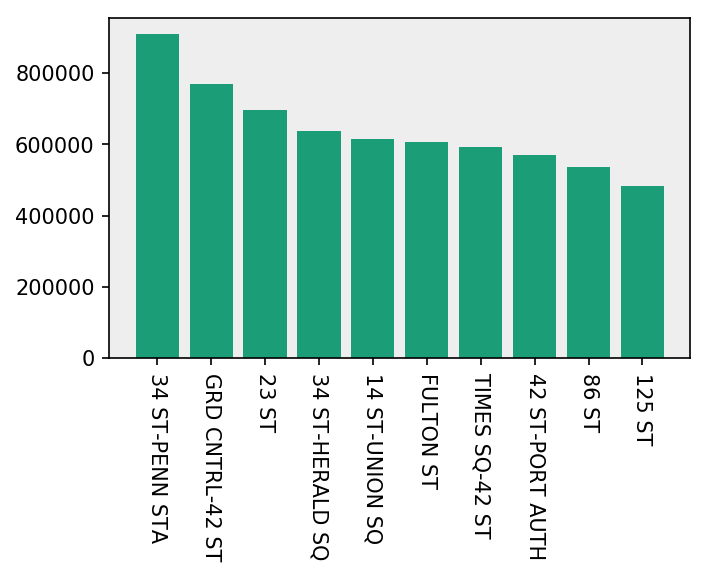

In [107]:
plt.bar(range(len(sorted_station_net_entries.index[0:10])), \
        sorted_station_net_entries.net_entries[0:10], \
        tick_label = sorted_station_net_entries.index[0:10])
plt.xticks(rotation = 270)
plt.show()